Milestone 1: The curl of a vector field

In the first milestone, you will implement the curl of a vector field using a Fourier spectral method. The goal is to

    …understand how to compute the curl with Fourier-spectral methods.

Curl

In your project you will implement a pseudospectral solver for the Navier-Stokes equations. We will guide you step-by-step through creating this code. This initial milestone explains how to compute the curl, that is a nessary operation for computing the Navier-Stokes equation in the rotational form that we will use for the project.

The curl is a differential operation on a vector field. Given vector field $\vec{u}(\vec{r})$, which for the Navier-Stokes equation will be a velocity field, the curl is defined as
$$ \text{curl}\,\vec{u}=\nabla\times\vec{u}=\begin{pmatrix}\partial_y u_z - \partial_z u_y\\\partial_z u_x - \partial_x u_z\\\partial_x u_y - \partial_y u_x\end{pmatrix} $$
Task 1: Fourier-representation of the curl

Given a Fourier-series of the vector-field $\vec{u}(\vec{r})$, i.e.
$$\vec{u}(\vec{r})=\sum_{\vec{q}} \tilde{\vec{u}}(\vec{q}) e^{i \vec{q}\cdot\vec{r}}$$

with Fourier coefficients $\tilde{\vec{u}}(\vec{q})$, derive the expression for the curl in the Fourier representation.


In [69]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from muFFT import FFT
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [8, 8]

def u(x, y, z):
    return np.array([y**2 * z, -x * y, z**2])

Task 2: Implement a function computing the curl in real-space

Implement a function

$
nb\_ grid\_ pts = (32, 32, 2) \\
fft = FFT(nb\_ grid\_ pts, engine='pocketfft') \\
def \ curl(u\_ cxyz): \\
    """Computes \ the \ curl \ of \ a \ vector \ field \ in \ real \ space.""" \\
    fft... \\
    ... \\
$

that uses the Fourier-representation of the curl derived above to compute the curl of a real-space field. Use µFFT for the computation of the Fourier-transform.


In [68]:
%matplotlib inline
import numpy as np
from muFFT import FFT
from scipy.ndimage import map_coordinates

nb_grid_pts = (8, 8, 8)
fft = FFT(nb_grid_pts, engine='pocketfft')

def curl_muFFT(u_cxyz):
    u_x, u_y, u_z = u_cxyz

    u_x_rfield = fft.real_space_field('u_x rf')
    u_y_rfield = fft.real_space_field('u_y rf')
    u_z_rfield = fft.real_space_field('u_z rf')

    u_x_ffield = fft.fourier_space_field('u_x ff')
    u_y_ffield = fft.fourier_space_field('u_y ff')
    u_z_ffield = fft.fourier_space_field('u_z ff')

    u_x_rfield.p = u_x
    u_y_rfield.p = u_y
    u_z_rfield.p = u_z

    fft.fft(u_x_rfield, u_x_ffield)
    fft.fft(u_y_rfield, u_y_ffield)
    fft.fft(u_z_rfield, u_z_ffield)

    xfgrad = fft.fourier_space_field('xfgrad')
    yfgrad = fft.fourier_space_field('yfgrad')
    zfgrad = fft.fourier_space_field('zfgrad')

    kx = 2 * np.pi * fft.fftfreq[0]
    ky = 2 * np.pi * fft.fftfreq[1]
    kz = 2 * np.pi * fft.fftfreq[2]

    #print(xfgrad.p.shape)
    #print(u_z_ffield.p.shape)
    #print(u_y_ffield.p.shape)

    #print(fft.fftfreq.shape)

    xfgrad.p = 1j * ky * u_z_ffield.p - 1j * kz * u_y_ffield.p
    yfgrad.p = 1j * kz * u_x_ffield.p - 1j * kx * u_z_ffield.p
    zfgrad.p = 1j * kx * u_y_ffield.p - 1j * ky * u_x_ffield.p

    xgrad = fft.real_space_field('xgrad')
    ygrad = fft.real_space_field('ygrad')
    zgrad = fft.real_space_field('zgrad')

    fft.ifft(xfgrad, xgrad)
    fft.ifft(yfgrad, ygrad)
    fft.ifft(zfgrad, zgrad)

    curl_x = xgrad.p * fft.normalisation
    curl_y = ygrad.p * fft.normalisation
    curl_z = zgrad.p * fft.normalisation

    curl_u_xyz = np.array([curl_x, curl_y, curl_z])
    
    return curl_u_xyz

def curl_muFFT_maybe(u_cxyz):

    u_rfield = fft.real_space_field('u rf', (3,))
    u_ffield = fft.fourier_space_field('u ff', (3,))

    u_rfield.p = u_cxyz

    fft.fft(u_rfield, u_ffield)

    fgrad = fft.fourier_space_field('fgrad', (3,))
    grad = fft.real_space_field('grad', (3,))

    kx = 2 * np.pi * fft.fftfreq[0]
    ky = 2 * np.pi * fft.fftfreq[1]
    kz = 2 * np.pi * fft.fftfreq[2]

    fieldx = 1j * ky * u_ffield.p[2] - 1j * kz * u_ffield.p[1]
    fieldy = 1j * kz * u_ffield.p[0] - 1j * kx * u_ffield.p[2]
    fieldz = 1j * kx * u_ffield.p[1] - 1j * ky * u_ffield.p[0]

    fgrad.p = np.array([fieldx, fieldy, fieldz])

    fft.ifft(fgrad, grad)

    curl_u_xyz = grad.p * fft.normalisation

    return curl_u_xyz

Task 3: Test that a constant field has vanishing curl

As the first simplest test, check that a constant field leads to vanishing curl:

$
u\_ cxyz = np.ones([3, *fft.nb\_ subdomain\_ grid\_ pts]) \\
curlu\_ cxyz = curl(u\_ cxyz) \\
np.testing.assert\_ allclose(curlu\_ cxyz, 0) \\
$


In [71]:
%matplotlib inline

u_cxyz = np.ones([3, *fft.nb_subdomain_grid_pts])
muFFT_curlu_cxyz = curl_muFFT_maybe(u_cxyz)
np.testing.assert_allclose(muFFT_curlu_cxyz, 0)

print(muFFT_curlu_cxyz.shape)


# plt.plot(muFFT_curlu_cxyz[0,:,:,:], label='curl(u)_x')
# plt.plot(muFFT_curlu_cxyz[1,:,:,:], label='curl(u)_y')
# plt.plot(muFFT_curlu_cxyz[2,:,:,:], label='curl(u)_z')

(3, 8, 8, 8)


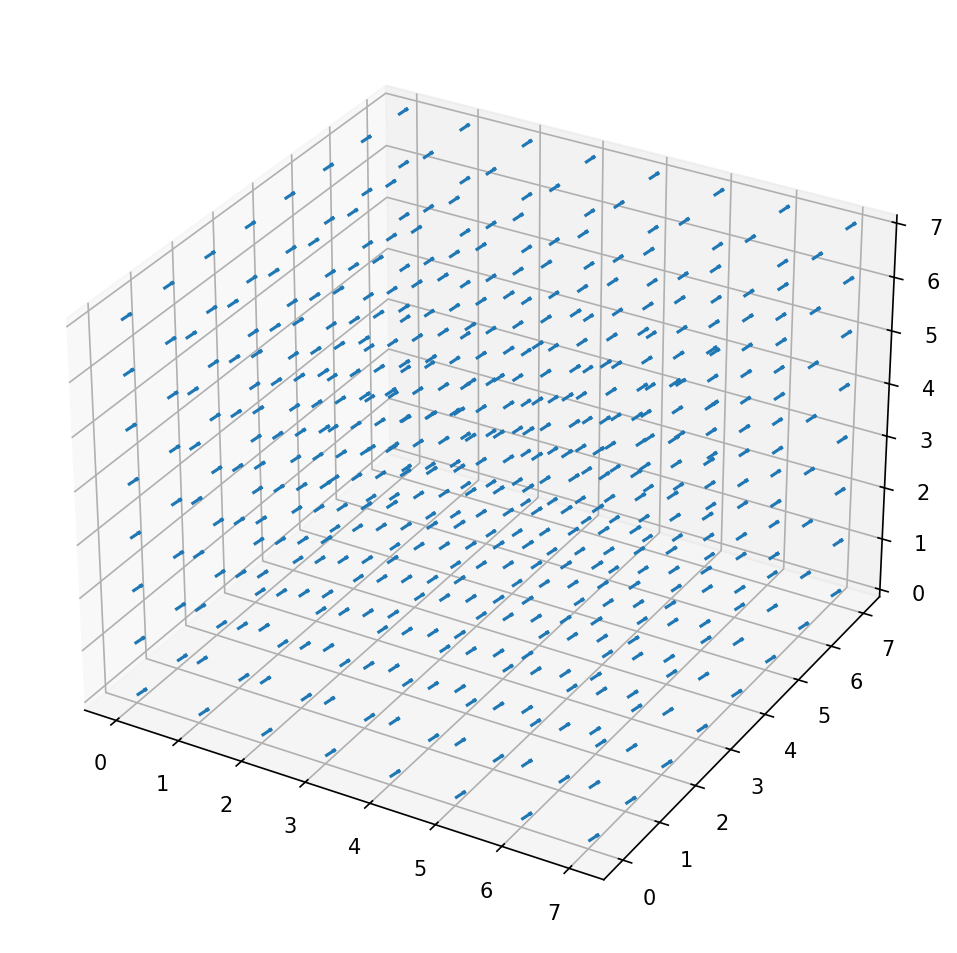

In [75]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z = np.meshgrid(np.arange(0, nb_grid_pts[0]), np.arange(0, nb_grid_pts[1]), np.arange(0, nb_grid_pts[2]))

u = u_cxyz[0]
v = u_cxyz[1]
w = u_cxyz[2]

ax.quiver(x, y, z, u, v, w, length=0.1)

plt.show()

(8, 8, 8)
(8, 8, 8)


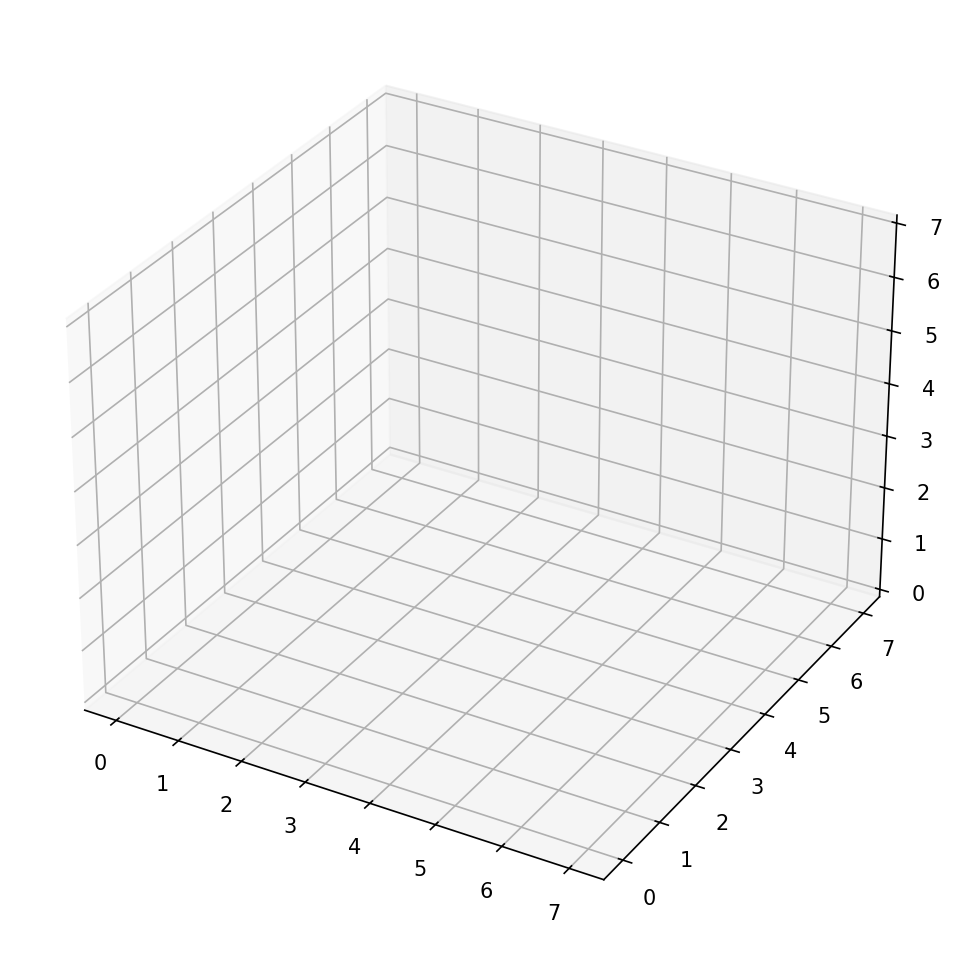

In [70]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z = np.meshgrid(np.arange(0, nb_grid_pts[0]), np.arange(0, nb_grid_pts[1]), np.arange(0, nb_grid_pts[2]))

u = muFFT_curlu_cxyz[0]
v = muFFT_curlu_cxyz[1]
w = muFFT_curlu_cxyz[2]

# print(curlu_cxyz.shape)
print(v.shape)
print(w.shape)

ax.quiver(x, y, z, u, v, w, length=0.1)

plt.show()


Task 4: Test nonvanishing curl

Compute the curl for the vector field generated by
Plot vector field and curl of the vector field. Which value of the curl would you expect? What do you see?

In [78]:
%matplotlib inline
norm = np.array([0, 0, 1])
u_cxyz_2 = np.cross(norm, fft.coords - 0.5, axis=0)

print(fft.coords - 0.5)

print(u_cxyz_2.shape)
print(u_cxyz_2)

muFFT_curlu_cxyz_2 = curl_muFFT_maybe(u_cxyz_2)

# plt.plot(muFFT_curlu_cxyz[0], label='curl(u)_x')
# plt.plot(muFFT_curlu_cxyz[1], label='curl(u)_y')
# plt.plot(muFFT_curlu_cxyz[2], label='curl(u)_z')

[[[[-0.5   -0.5   -0.5   ... -0.5   -0.5   -0.5  ]
   [-0.5   -0.5   -0.5   ... -0.5   -0.5   -0.5  ]
   [-0.5   -0.5   -0.5   ... -0.5   -0.5   -0.5  ]
   ...
   [-0.5   -0.5   -0.5   ... -0.5   -0.5   -0.5  ]
   [-0.5   -0.5   -0.5   ... -0.5   -0.5   -0.5  ]
   [-0.5   -0.5   -0.5   ... -0.5   -0.5   -0.5  ]]

  [[-0.375 -0.375 -0.375 ... -0.375 -0.375 -0.375]
   [-0.375 -0.375 -0.375 ... -0.375 -0.375 -0.375]
   [-0.375 -0.375 -0.375 ... -0.375 -0.375 -0.375]
   ...
   [-0.375 -0.375 -0.375 ... -0.375 -0.375 -0.375]
   [-0.375 -0.375 -0.375 ... -0.375 -0.375 -0.375]
   [-0.375 -0.375 -0.375 ... -0.375 -0.375 -0.375]]

  [[-0.25  -0.25  -0.25  ... -0.25  -0.25  -0.25 ]
   [-0.25  -0.25  -0.25  ... -0.25  -0.25  -0.25 ]
   [-0.25  -0.25  -0.25  ... -0.25  -0.25  -0.25 ]
   ...
   [-0.25  -0.25  -0.25  ... -0.25  -0.25  -0.25 ]
   [-0.25  -0.25  -0.25  ... -0.25  -0.25  -0.25 ]
   [-0.25  -0.25  -0.25  ... -0.25  -0.25  -0.25 ]]

  ...

  [[ 0.125  0.125  0.125 ...  0.125  0.125  0.12

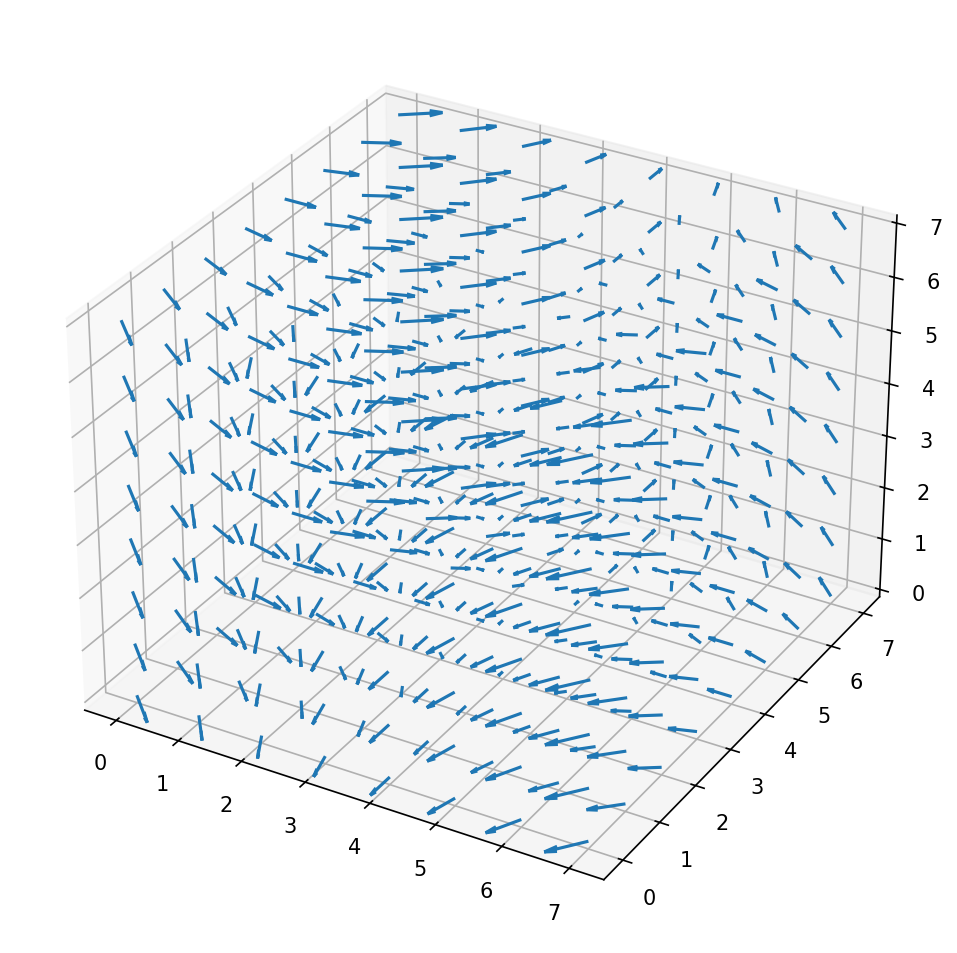

In [72]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z = np.meshgrid(np.arange(0, nb_grid_pts[0]), np.arange(0, nb_grid_pts[1]), np.arange(0, nb_grid_pts[2]))

u = u_cxyz_2[0]
v = u_cxyz_2[1]
w = u_cxyz_2[2]

ax.quiver(x, y, z, u, v, w, length=1)

plt.show()

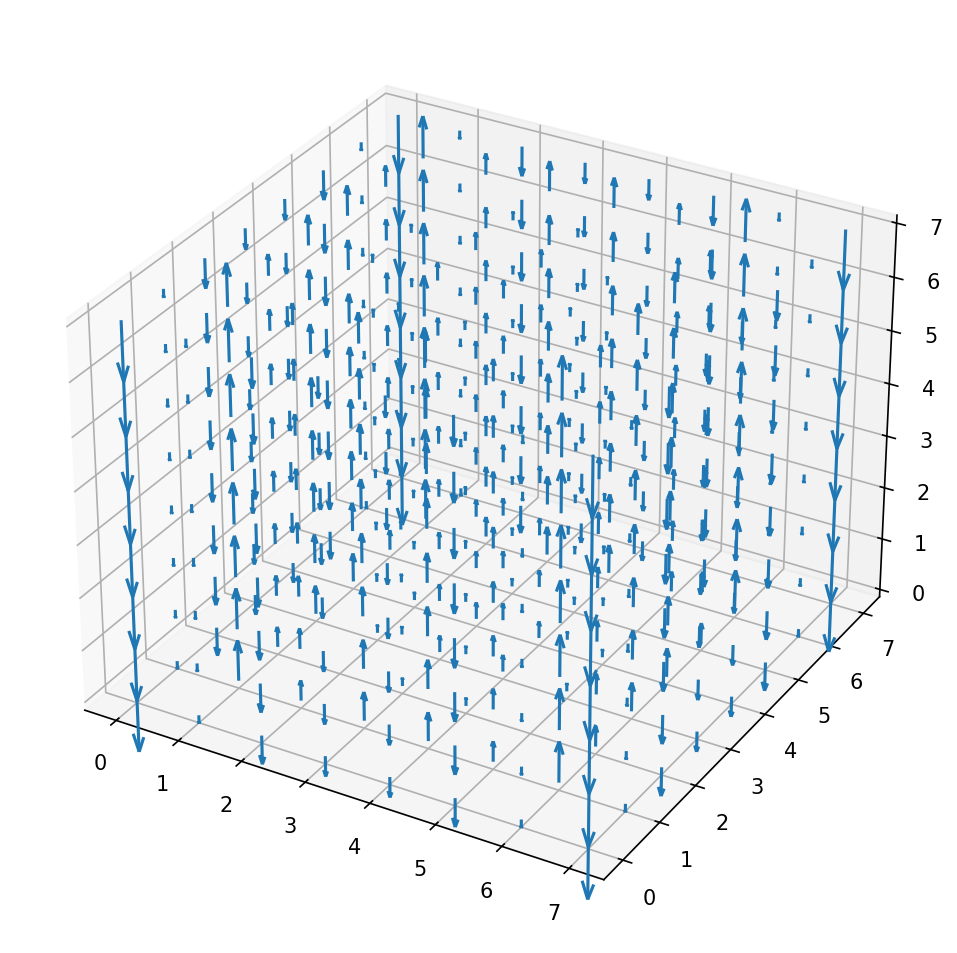

In [74]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z = np.meshgrid(np.arange(0, nb_grid_pts[0]), np.arange(0, nb_grid_pts[1]), np.arange(0, nb_grid_pts[2]))

u = muFFT_curlu_cxyz_2[0]
v = muFFT_curlu_cxyz_2[1]
w = muFFT_curlu_cxyz_2[2]

ax.quiver(x, y, z, u, v, w, length=1)

plt.show()

In [76]:
%matplotlib inline
norm = np.array([1, 0, 0])
u_cxyz_3 = np.cross(norm, fft.coords - 0.5, axis=0)

print(u_cxyz_3.shape)
print(u_cxyz_3)

muFFT_curlu_cxyz_3 = curl_muFFT_maybe(u_cxyz_3)

# plt.plot(muFFT_curlu_cxyz[0], label='curl(u)_x')
# plt.plot(muFFT_curlu_cxyz[1], label='curl(u)_y')
# plt.plot(muFFT_curlu_cxyz[2], label='curl(u)_z')

(3, 8, 8, 8)
[[[[ 0.     0.     0.    ...  0.     0.     0.   ]
   [ 0.     0.     0.    ...  0.     0.     0.   ]
   [ 0.     0.     0.    ...  0.     0.     0.   ]
   ...
   [-0.    -0.    -0.    ...  0.     0.     0.   ]
   [-0.    -0.    -0.    ...  0.     0.     0.   ]
   [-0.    -0.    -0.    ...  0.     0.     0.   ]]

  [[ 0.     0.     0.    ...  0.     0.     0.   ]
   [ 0.     0.     0.    ...  0.     0.     0.   ]
   [ 0.     0.     0.    ...  0.     0.     0.   ]
   ...
   [-0.    -0.    -0.    ...  0.     0.     0.   ]
   [-0.    -0.    -0.    ...  0.     0.     0.   ]
   [-0.    -0.    -0.    ...  0.     0.     0.   ]]

  [[ 0.     0.     0.    ...  0.     0.     0.   ]
   [ 0.     0.     0.    ...  0.     0.     0.   ]
   [ 0.     0.     0.    ...  0.     0.     0.   ]
   ...
   [-0.    -0.    -0.    ...  0.     0.     0.   ]
   [-0.    -0.    -0.    ...  0.     0.     0.   ]
   [-0.    -0.    -0.    ...  0.     0.     0.   ]]

  ...

  [[ 0.     0.     0.    ...  0.   

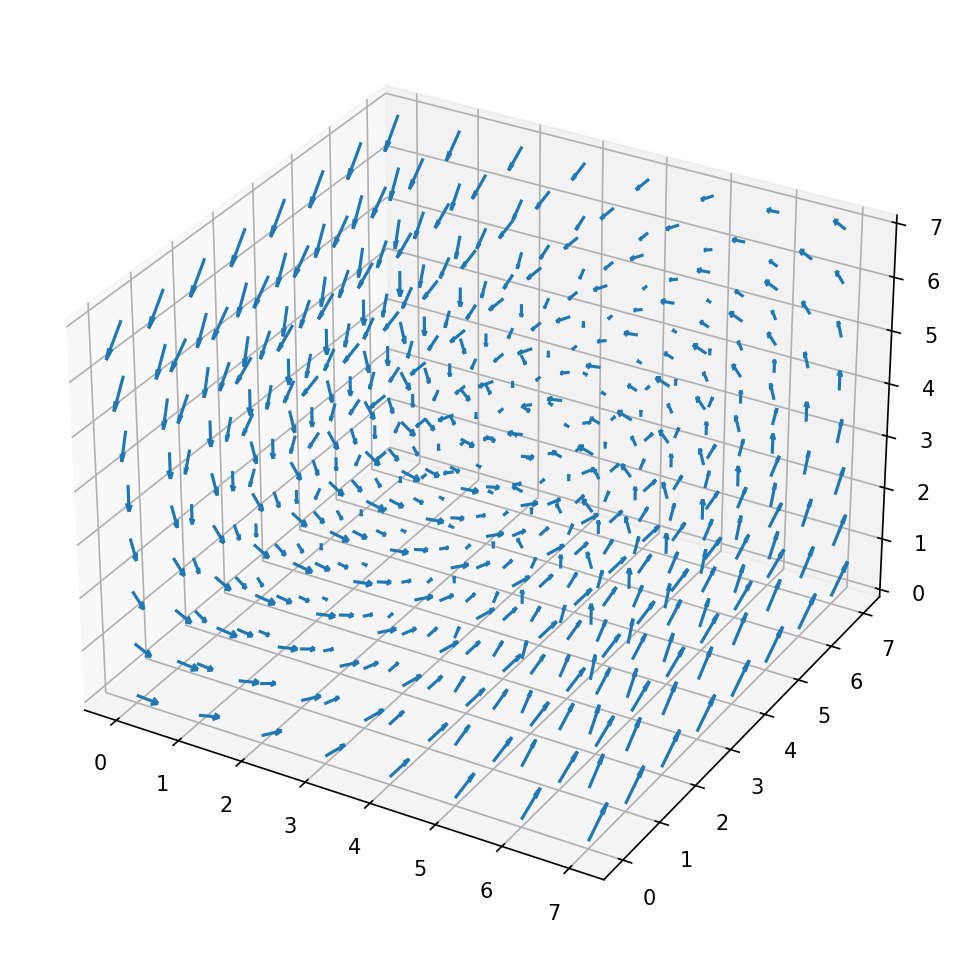

In [73]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z = np.meshgrid(np.arange(0, nb_grid_pts[0]), np.arange(0, nb_grid_pts[1]), np.arange(0, nb_grid_pts[2]))

u = u_cxyz_3[0]
v = u_cxyz_3[1]
w = u_cxyz_3[2]

ax.quiver(x, y, z, u, v, w, length=1)

plt.show()

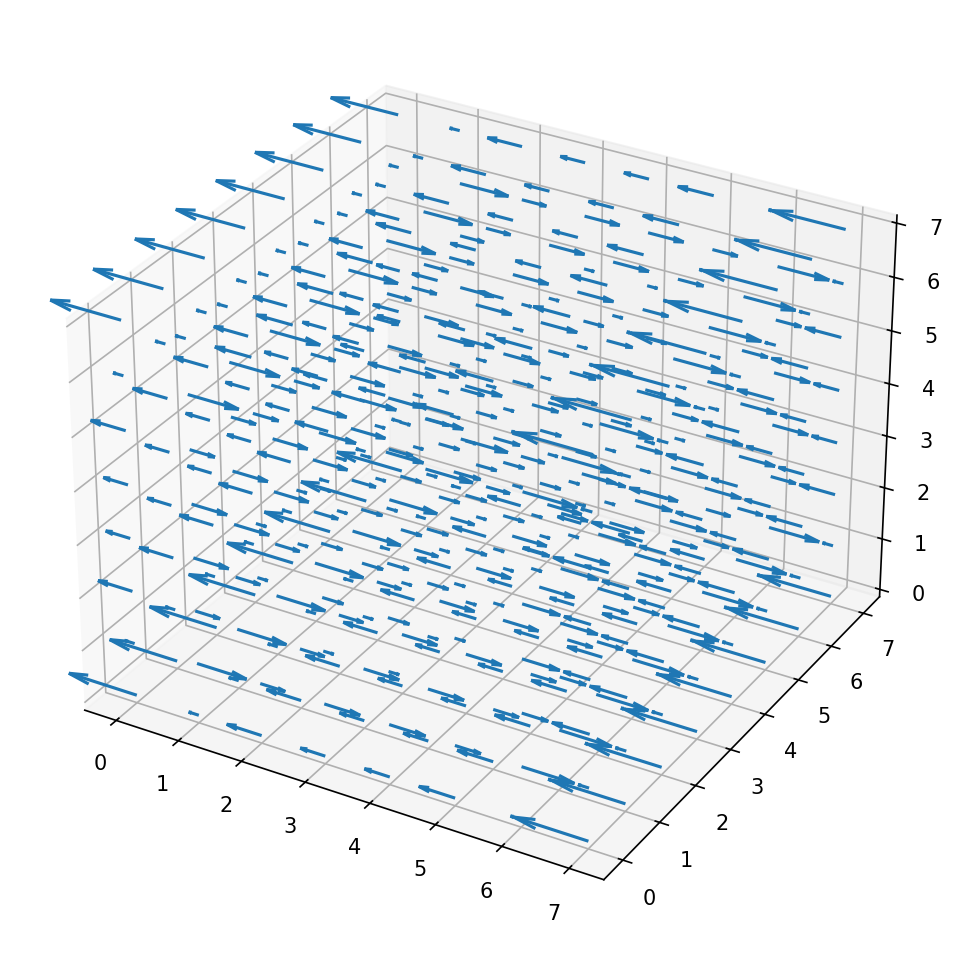

In [77]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z = np.meshgrid(np.arange(0, nb_grid_pts[0]), np.arange(0, nb_grid_pts[1]), np.arange(0, nb_grid_pts[2]))

u = muFFT_curlu_cxyz_3[0]
v = muFFT_curlu_cxyz_3[1]
w = muFFT_curlu_cxyz_3[2]

ax.quiver(x, y, z, u, v, w, length=1)

plt.show()